In [1]:
import h5py
import numpy as  np
import matplotlib.pyplot as plt
from source import helper
plt.rcParams["figure.figsize"] = (20,5)
plt.rcParams["image.interpolation"] = 'none'
import tensorflow as tf
from IPython.display import display, clear_output
from collections import deque
import time

In [2]:
import logging
logging.getLogger('tensorflow').setLevel(logging.WARNING)

In [3]:
H5_FILENAME = 'final_dataset'
loaded_file = h5py.File('data/'+ H5_FILENAME + '.h5','r')

In [4]:
path_model = tf.keras.models.load_model('data/models/model_8.h5')
classification_model = tf.keras.models.load_model('data/models/class_conv3d_(15,15).h5')

In [5]:
keys = list(loaded_file.keys())
_ = [print(f'{i}: {k}') for i,k in enumerate(keys)]

0: background
1: bartek
2: kuba
3: oddychacz_2m_o0_s100
4: oddychacz_2m_o30_s0
5: oddychacz_2m_o30_s100
6: oddychacz_3m_o0_s100
7: oddychacz_3m_o30_s0
8: oddychacz_3m_o30_s100
9: oddychacz_4m_o0_s100
10: oddychacz_4m_o30_s0
11: oddychacz_4m_o30_s100
12: oskar
13: rafal
14: randomowe_chodzonko_bartek
15: randomowe_chodzonko_kuba
16: randomowe_chodzonko_oskar
17: randomowe_chodzonko_rafal
18: samochod
19: samples
20: wiatrak_2m
21: wiatrak_3m
22: wiatrak_4m
23: wiatrak_foliarz_2m
24: wiatrak_foliarz_3m
25: wiatrak_foliarz_4m


In [21]:
file = 15
background = loaded_file['background']
distances = [1,2,5,10,20,50]
max_depth = 50

frames = loaded_file[keys[file]]
frames = helper.subtract_background(background, frames)




In [22]:
def normalize(array: np.array) -> np.array:
    return (array + 50) / (190 + 50)

KeyboardInterrupt: 

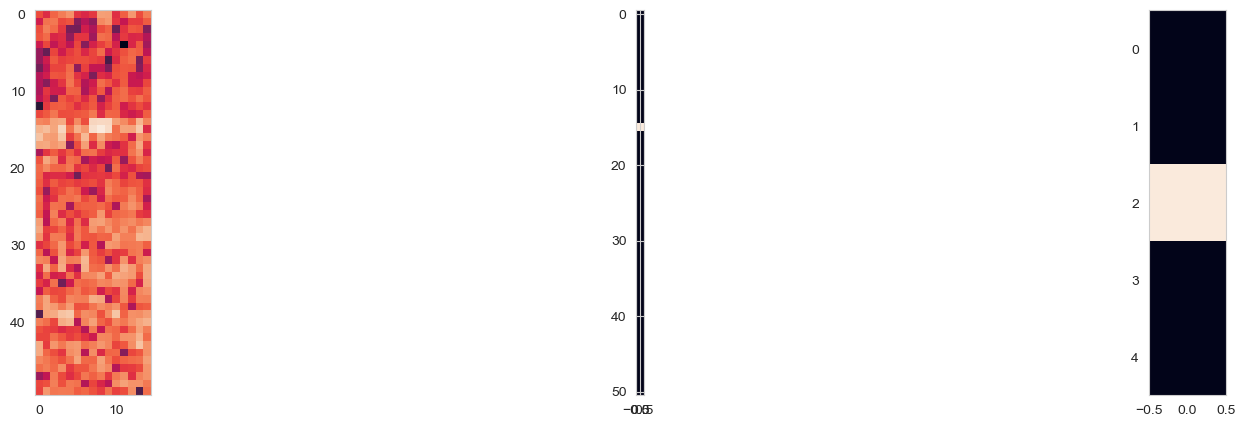

In [27]:
# fig = plt.figure()
# ax = fig.add_subplot(1, 2)
f, ax = plt.subplots(1,3)
buffer = deque(maxlen=65)
start = time.perf_counter()

for frame in frames[:2000]:
    buffer.append(frame)
    if len(buffer) == 65:
        frames_buffer = np.array(buffer)
        spects,y = helper.gen_n_diff_spect(frames_buffer, distances=distances)
        spects = np.array(spects)
        spects = spects[:,:50,:]

        normalized_spects = [normalize(s) for s in spects]
        normalized_spects = np.array(normalized_spects)
        to_path_predict = np.expand_dims(normalized_spects[:,:,-10:], axis=0)

        position_prediction = path_model.predict(to_path_predict,verbose=0)
        position = np.argmax(position_prediction)
        bar = np.zeros((51,1))
        bar[position] = 1

        window_size = (15,15)
        y_dim = window_size[1] // 2
        x_dim = window_size[0]

        window = np.expand_dims(normalized_spects[:,position-y_dim:position+y_dim+1,:], axis=0)
        obj_class = np.zeros((5,1))
        if window.shape[2:] == window_size:
            pred = classification_model.predict(window,verbose=0)
            pred = np.argmax(pred)
            obj_class[pred] = 1

        # print(f'pos:{position} class:{pred}')
        ax[0].cla()
        ax[0].imshow(normalized_spects[0], )
        ax[0].grid(False)

        ax[1].cla()
        ax[1].imshow(bar)
        ax[1].grid(False)

        ax[2].cla()
        ax[2].imshow(obj_class)
        ax[2].grid(False)
        display(f)

        clear_output(wait = True)
print(time.perf_counter() - start)

In [12]:
background = loaded_file['background']
distances = [1, 2, 5, 10, 20, 50]
max_depth = 50

frames = loaded_file[keys[file]]
frames = helper.subtract_background(background, frames)

frames = loaded_file[keys[file]]
frames = helper.subtract_background(background, frames)
spects,y = helper.gen_n_diff_spect(frames, distances=distances)
spects = np.array(spects)
spects = spects[:,:50,:]

spects = [helper.normalize(s) for s in spects]
spects = np.array(spects)



In [14]:
np.max(spects)

1.0

In [15]:
frames2 = np.swapaxes(spects, 0, 2)
frames2.shape

(6181, 50, 6)

KeyboardInterrupt: 

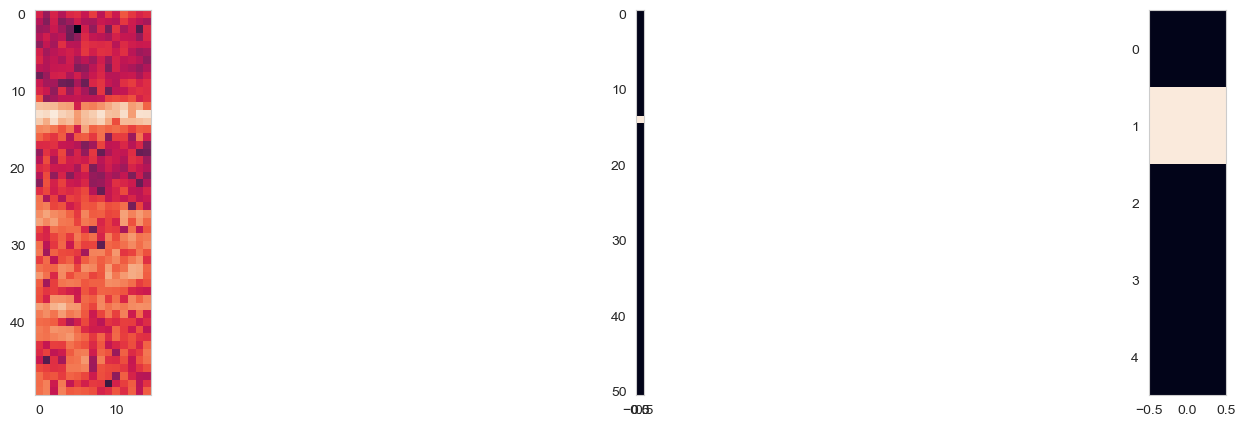

In [29]:
# fig = plt.figure()
# ax = fig.add_subplot(1, 2)
f, ax = plt.subplots(1,3)
buffer = deque(maxlen=15)
start = time.perf_counter()
i=0
obj_class = np.zeros((5,1))
bar = np.zeros((51,1))
for frame in frames2[1000:2000]:
    i+=1
    buffer.append(frame.T)
    if len(buffer) == 15:
        frames_buffer = np.array(buffer)
        frames_buffer = np.moveaxis(frames_buffer, 0, 2)

        if i % 10:
            to_path_predict = np.expand_dims(frames_buffer[:,:,-10:], axis=0)

            position_prediction = path_model.predict(to_path_predict,verbose=0)
            position = np.argmax(position_prediction)
            bar = np.zeros((51,1))
            bar[position] = 1

            window_size = (15,15)
            y_dim = window_size[1] // 2
            x_dim = window_size[0]

            window = np.expand_dims(frames_buffer[:,position-y_dim:position+y_dim+1,:], axis=0)

            if window.shape[2:] == window_size:
                pred = classification_model.predict(window,verbose=0)
                pred = np.argmax(pred)
                obj_class = np.zeros((5,1))
                obj_class[pred] = 1

        # print(f'{i}\tpos:{position}\tclass:{pred}')
        ax[0].cla()
        ax[0].imshow(frames_buffer[1], )
        ax[0].grid(False)

        ax[1].cla()
        ax[1].imshow(bar)
        ax[1].grid(False)

        ax[2].cla()
        ax[2].imshow(obj_class)
        ax[2].grid(False)
        display(f)

        clear_output(wait = True)
        # plt.pause(1)
print(time.perf_counter() - start)